In [ ]:
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
import tensorflow as tf
from keras import layers, models
from keras import optimizers, metrics
import numpy as np
import pathlib
from google.colab import drive
from keras import regularizers
import matplotlib.pyplot as plt

## Pre-processing

Load LR- and HR-images saved in drive. Resize LR-images using Bicubic interpolation to get them to the HR size. Create tensorflow datasets for efficient memory usage.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#define constants
HIGH_RES = 224
LOW_RES = 112

N_TRAIN = 1152
N_VAL = 384
N_TEST = 512

batch_size = 16

#images stored in google drive in separate files for low and high resolution
high_res_dir = pathlib.Path('/content/drive/MyDrive/ST456_project_team_afi/high_res_images')
low_res_dir = pathlib.Path('/content/drive/MyDrive/ST456_project_team_afi/low_res_images')

high_res_paths = sorted([str(path) for path in high_res_dir.glob('*.jpg')])
low_res_paths = sorted([str(path) for path in low_res_dir.glob('*.jpg')])

#training, validation and test split
train_high_res_paths = high_res_paths[:N_TRAIN]
train_low_res_paths = low_res_paths[:N_TRAIN]

val_high_res_paths = high_res_paths[N_TRAIN:N_TRAIN+N_VAL]
val_low_res_paths = low_res_paths[N_TRAIN:N_TRAIN+N_VAL]

test_high_res_paths = high_res_paths[N_TRAIN+N_VAL:]
test_low_res_paths = low_res_paths[N_TRAIN+N_VAL:]

#define functions for preprocessing such as scaling in the range [-1,1]
def normalize_images(low_res_img, high_res_img):
  """
  Normalize images to [-1, 1].

  Args:
    low_res_img: Low resolution image.
    high_res_img: High resolution image.

  Returns:
    low_res_img: Low resolution image scaled to [-1, 1].
    high_res_img: High resolution image scaled to [-1, 1].
  """
  low_res_img = tf.cast(low_res_img, dtype=tf.float32) / 127.5 - 1.0
  high_res_img = tf.cast(high_res_img, dtype=tf.float32) / 127.5 - 1.0

  return low_res_img, high_res_img

#decode images, scale LR images and normalize in correct range
def train_preprocessing(low_res_path, high_res_path):
  """
  Preprocessing pairs of images.

  Args:
    low_res_path: Low resolution image path.
    high_res_path: High resolution image path.

  Returns:
    low_res_img: Low resolution image.
    high_res_img: High resolution image.

  """
  low_res_img = tf.io.read_file(low_res_path)
  low_res_img = tf.image.decode_jpeg(low_res_img, channels=3)
  high_res_img = tf.io.read_file(high_res_path)
  high_res_img = tf.image.decode_jpeg(high_res_img, channels=3)

  #resize LR-images using bicubic interpolation
  low_res_img = tf.image.resize(low_res_img, [HIGH_RES, HIGH_RES], method=tf.image.ResizeMethod.BICUBIC)

  low_res_img, high_res_img = normalize_images(low_res_img, high_res_img)

  return low_res_img, high_res_img

#create datasets
def create_dataset(low_res_paths, high_res_paths, batch_size, is_training=True):
  """
  Create tensorflow parallel map dataset using low and high resolution image paths.

  Args:
    low_res_paths: Low resolution image paths.
    high_res_paths: High resolution image paths.
    batch_size: Batch size.
    is_training: Whether the dataset is for training or validation.

  Returns:
    ds: Dataset.
  """
  ds = tf.data.Dataset.from_tensor_slices((low_res_paths, high_res_paths))
  ds = ds.map(train_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
  if is_training:
      ds = ds.shuffle(buffer_size=len(low_res_paths))
  ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
  return ds

train_ds = create_dataset(train_low_res_paths, train_high_res_paths, batch_size, is_training=True)
val_ds = create_dataset(val_low_res_paths, val_high_res_paths, batch_size, is_training=False)
test_ds = create_dataset(test_low_res_paths, test_high_res_paths, batch_size, is_training=False)

## Model Definition

Define building blocks for denoising U-Net and put them together.

In [ ]:
#timestep encoding allowing the U-Net to utilize the temporal aspect of noise application in its denoising process. Similar to positional encoding in transformers.
class GammaEncoding(layers.Layer):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.dense = layers.Dense(dim)
        self.act = layers.LeakyReLU()

    def call(self, noise_level):
        noise_level = tf.cast(noise_level, tf.float32)
        noise_level = tf.expand_dims(tf.expand_dims(tf.expand_dims(noise_level, -1), -1), -1)
        count = self.dim // 2
        step = tf.range(count, dtype=tf.float32) / count
        encoding = noise_level * tf.exp(tf.math.log(1e4) * step[tf.newaxis, :])
        encoding = tf.concat([tf.math.sin(encoding), tf.math.cos(encoding)], axis=-1)
        return self.act(self.dense(encoding))

#define convolutional block, see Figure 1
class ConvBlock(layers.Layer):
    def __init__(self, in_c, out_c, time_steps=1000, activation="relu", dropout_rate=0.01, reg_lambda=0.01):
        super().__init__()
        self.conv1 = layers.Conv2D(out_c, (3, 3), padding="same", kernel_regularizer=regularizers.l2(reg_lambda))
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.ReLU() if activation == "relu" else layers.Activation('silu')
        self.dropout1 = layers.Dropout(dropout_rate)
        self.conv2 = layers.Conv2D(out_c, (3, 3), padding="same", kernel_regularizer=regularizers.l2(reg_lambda))
        self.bn2 = layers.BatchNormalization()
        self.act2 = layers.ReLU() if activation == "relu" else layers.Activation('silu')
        self.dropout2 = layers.Dropout(dropout_rate)
        self.embedding = GammaEncoding(out_c)

    def call(self, inputs, time, training=False):
        time_embedding = self.embedding(time)
        time_embedding = tf.reshape(time_embedding, (-1, 1, 1, self.embedding.dim))
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.act1(x)
        x = self.dropout1(x, training=training)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.act2(x)
        x = self.dropout2(x, training=training)
        x = x + time_embedding
        return x

#define encoder block based on convolutional block, see Figure 2
class EncoderBlock(layers.Layer):
    def __init__(self, in_c, out_c, time_steps, activation="relu"):
        super().__init__()
        self.conv_block = ConvBlock(in_c, out_c, time_steps, activation)
        self.pool = layers.MaxPooling2D((2, 2))

    def call(self, inputs, time):
        x = self.conv_block(inputs, time)
        p = self.pool(x)
        return x, p

#define decoder block based on convolutional block, see Figure 2
class DecoderBlock(layers.Layer):
    def __init__(self, in_c, out_c, time_steps, activation="relu"):
        super().__init__()
        self.up = layers.Conv2DTranspose(in_c, (2, 2), strides=(2, 2))
        self.conv_block = ConvBlock(in_c + out_c, out_c, time_steps, activation)

    def call(self, inputs, skip, time):
        x = self.up(inputs)
        x = layers.concatenate([x, skip], axis=-1)
        x = self.conv_block(x, time)
        return x


#define U-Net architecture, see Figure 2
# @tf.keras.saving.register_keras_serializable()
class UNet(models.Model):
    def __init__(self, input_channels, output_channels, time_steps):
        super().__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.time_steps = time_steps

        self.e1 = EncoderBlock(self.input_channels, 64, time_steps=self.time_steps)
        self.e2 = EncoderBlock(64, 128, time_steps=self.time_steps)
        self.e3 = EncoderBlock(128, 256, time_steps=self.time_steps)
        self.e4 = EncoderBlock(256, 512, time_steps=self.time_steps)

        self.b = ConvBlock(512, 1024, time_steps=self.time_steps)

        self.d1 = DecoderBlock(1024, 512, time_steps=self.time_steps)
        self.d2 = DecoderBlock(512, 256, time_steps=self.time_steps)
        self.d3 = DecoderBlock(256, 128, time_steps=self.time_steps)
        self.d4 = DecoderBlock(128, 64, time_steps=self.time_steps)

        self.outputs = layers.Conv2D(self.output_channels, kernel_size=1, padding="same")

    def call(self, inputs, time):
        upsampled_low_res_image, current_noisy_image = inputs

        x = tf.concat([upsampled_low_res_image, current_noisy_image], axis=-1)

        s1, p1 = self.e1(x, time)
        s2, p2 = self.e2(p1, time)
        s3, p3 = self.e3(p2, time)
        s4, p4 = self.e4(p3, time)
        b = self.b(p4, time)
        d1 = self.d1(b, s4, time)
        d2 = self.d2(d1, s3, time)
        d3 = self.d3(d2, s2, time)
        d4 = self.d4(d3, s1, time)
        outputs = self.outputs(d4)
        return outputs

Define diffusion process

In [ ]:
#define Diffusion model using U-Net
@tf.keras.saving.register_keras_serializable()
class DiffusionModel(models.Model):
    def __init__(self, time_steps, beta_start=1e-4, beta_end=0.02, image_dims=(224, 224, 3)):
        super().__init__()
        self.time_steps = time_steps
        self.image_dims = image_dims
        self.model = UNet(input_channels=image_dims[-1] * 2, output_channels=image_dims[-1], time_steps=time_steps)
        self.betas = tf.linspace(beta_start, beta_end, self.time_steps)
        self.alphas = 1.0 - self.betas
        self.alpha_hats = tf.math.cumprod(self.alphas, axis=0)

    def call(self, inputs, ts, training=False):
        return self.model(inputs, ts, training=training)


    def add_noise(self, x, ts):
        noise = tf.random.normal(shape=tf.shape(x))
        alpha_hat_t = tf.gather(self.alpha_hats, ts)
        alpha_hat_t = tf.reshape(alpha_hat_t, [-1, 1, 1, 1])

        #apply the noise. Don't sample gamma to reduce complexity.
        noised_images = tf.sqrt(alpha_hat_t) * x + tf.sqrt(1.0 - alpha_hat_t) * noise
        return noised_images, noise

In [ ]:
model = DiffusionModel(time_steps=1000, beta_start=1e-4, beta_end=0.02, image_dims=(224, 224, 3))

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')
# model.load_weights("/content/drive/MyDrive/ST456_project_team_afi/0_SR3_final/SR3_weights.h5")

## Training

Define the custom training function based on Algorithm 1 in Saharia et al. (2021)

In [ ]:
def train_model(model, train_ds, val_ds, epochs=10):
  """
  Train diffusion model.

  Args:
      model (DiffusionModel): Diffusion model.
      train_ds (tf.data.Dataset): Training dataset.
      val_ds (tf.data.Dataset): Validation dataset.
      epochs (int): Number of epochs.
  """
  optimizer = tf.keras.optimizers.Adam()
  for epoch in tqdm(range(epochs)):
      print(f"Epoch {epoch+1}/{epochs}")
      # Training phase
      total_loss = 0
      for low_res_images, high_res_images in train_ds:
          #sample time step
          ts = tf.random.uniform((low_res_images.shape[0],), minval=0, maxval=model.time_steps, dtype=tf.int32)
          #noise images directly based on timestep, avoid sampling gamma for efficiency
          noisy_images, actual_noise = model.add_noise(high_res_images, ts)
          inputs = [low_res_images, noisy_images]
          #take gradient descent step
          with tf.GradientTape() as tape:
              predicted_noise = model(inputs, ts, training=True)
              loss = tf.reduce_mean(tf.square(actual_noise - predicted_noise))
          gradients = tape.gradient(loss, model.trainable_variables)
          optimizer.apply_gradients(zip(gradients, model.trainable_variables))
          total_loss += loss

      train_loss = total_loss / len(train_ds)

      # Validation phase
      total_val_loss = 0
      for low_res_images, high_res_images in val_ds:
          ts = tf.random.uniform((low_res_images.shape[0],), minval=0, maxval=model.time_steps, dtype=tf.int32)
          noisy_images, actual_noise = model.add_noise(high_res_images, ts)
          inputs = [low_res_images, noisy_images]
          predicted_noise = model(inputs, ts, training=False)
          val_loss = tf.reduce_mean(tf.square(actual_noise - predicted_noise))
          total_val_loss += val_loss

      val_loss = total_val_loss / len(val_ds)

      print(f"Loss after epoch {epoch+1}: Train = {train_loss.numpy()}, Val = {val_loss.numpy()}")

In [ ]:
train_model(model, train_ds, val_ds, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50


Loss after epoch 1: Train = 0.6964922547340393, Val = 6364.55712890625
Epoch 2/50
Loss after epoch 2: Train = 0.18936938047409058, Val = 1.0114398002624512
Epoch 3/50
Loss after epoch 3: Train = 0.13727523386478424, Val = 0.5318527817726135
Epoch 4/50
Loss after epoch 4: Train = 0.11416821926832199, Val = 0.184210404753685
Epoch 5/50
Loss after epoch 5: Train = 0.09699802845716476, Val = 0.10806597024202347
Epoch 6/50
Loss after epoch 6: Train = 0.08728945255279541, Val = 0.10706313699483871
Epoch 7/50
Loss after epoch 7: Train = 0.07771969586610794, Val = 0.08573317527770996
Epoch 8/50
Loss after epoch 8: Train = 0.07385218143463135, Val = 0.08528521656990051
Epoch 9/50
Loss after epoch 9: Train = 0.06540100276470184, Val = 0.05814880132675171
Epoch 10/50
Loss after epoch 10: Train = 0.06610795110464096, Val = 4.795308589935303
Epoch 11/50
Loss after epoch 11: Train = 0.06176234036684036, Val = 0.06669971346855164
Epoch 12/50
Loss after epoch 12: Train = 0.054699644446372986, Val = 0.

In [ ]:
model.save_weights('/content/drive/MyDrive/SR3_weights.h5')

## Testing / Inference

Load the model from saved weights to perform inference

In [ ]:
#Load model from weights
model = DiffusionModel(time_steps=1000, beta_start=1e-4, beta_end=0.02, image_dims=(224, 224, 3))

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

#create dummy to load model
dummy_low_res_image = np.random.random((1, 224, 224, 3)).astype(np.float32)
dummy_high_res_image = np.random.random((1, 224, 224, 3)).astype(np.float32)
dummy_ts = np.array([0], dtype=np.int32)
noisy_images, _ = model.add_noise(dummy_high_res_image, dummy_ts)
inputs = [dummy_low_res_image, noisy_images]
_ = model(inputs, dummy_ts, training=False)

#load weights
model.load_weights('/content/drive/MyDrive/ST456_project_team_afi/0_SR3_final/SR3_weights.h5')

Define custom function for inference

In [ ]:
#define inference, compare algorithm 2 in the SR3 paper (Saharia et al., 2021)
def perform_inference(model, low_res_batch, time_steps):
  """
  Perform inference on a batch of low-resolution images.

  Args:
      model (DiffusionModel): Diffusion model.
      low_res_batch (tf.Tensor): Batch of low-resolution images.
      time_steps (int): Number of time steps.

  Returns:
      tf.Tensor: Batch of super-resolved images.
  """
  #start from Gaussian noise
  current_image = tf.random.normal(low_res_batch.shape, stddev=np.sqrt(1/255))
  #calculate alphas and gammas
  alphas = model.alphas.numpy()
  gammas = model.alpha_hats.numpy()

  for t in reversed(range(time_steps)):
      #sample Gaussian noise
      if t > 0:
          z = tf.random.normal(low_res_batch.shape, stddev=np.sqrt(1/255))
      else:
          z = tf.zeros(low_res_batch.shape, dtype=tf.float32)

      ts_tensor = tf.fill([current_image.shape[0]], t)
      ts_tensor = tf.cast(ts_tensor, tf.int32)

      #predict noise with model
      predicted_noise = model([low_res_batch, current_image], ts_tensor, training=False)

      #iterative refinement step based on predicted noise
      if t > 0:
          current_image = (1/alphas[t]) * (current_image - ((1-alphas[t]) / np.sqrt(1-gammas[t])) * predicted_noise) + np.sqrt(1-alphas[t]) * z

  final_image = (current_image + 1) * 127.5
  final_image = tf.clip_by_value(final_image, 0, 255)
  final_image = tf.cast(final_image, tf.uint8)

  return final_image

Perform inference on small subset for visualisation and testing purposes since inference is very expensive



In [ ]:
image_data = []

N_VISUALISATION = 3

for low_res_batch, high_res_batch in test_ds.take(1):
    low_res_batch = low_res_batch[:N_VISUALISATION]
    high_res_batch = high_res_batch[:N_VISUALISATION]

    sr_batch = perform_inference(model, low_res_batch, time_steps=400)


    sr_batch = tf.cast(sr_batch, tf.float32)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.cast(sr_batch, tf.uint8)

    for lr_img, sr_img, hr_img in zip(low_res_batch, sr_batch, high_res_batch):
        lr_img = lr_img.numpy()
        sr_img = sr_img.numpy()
        hr_img = hr_img.numpy()
        image_data.append((lr_img, sr_img, hr_img))

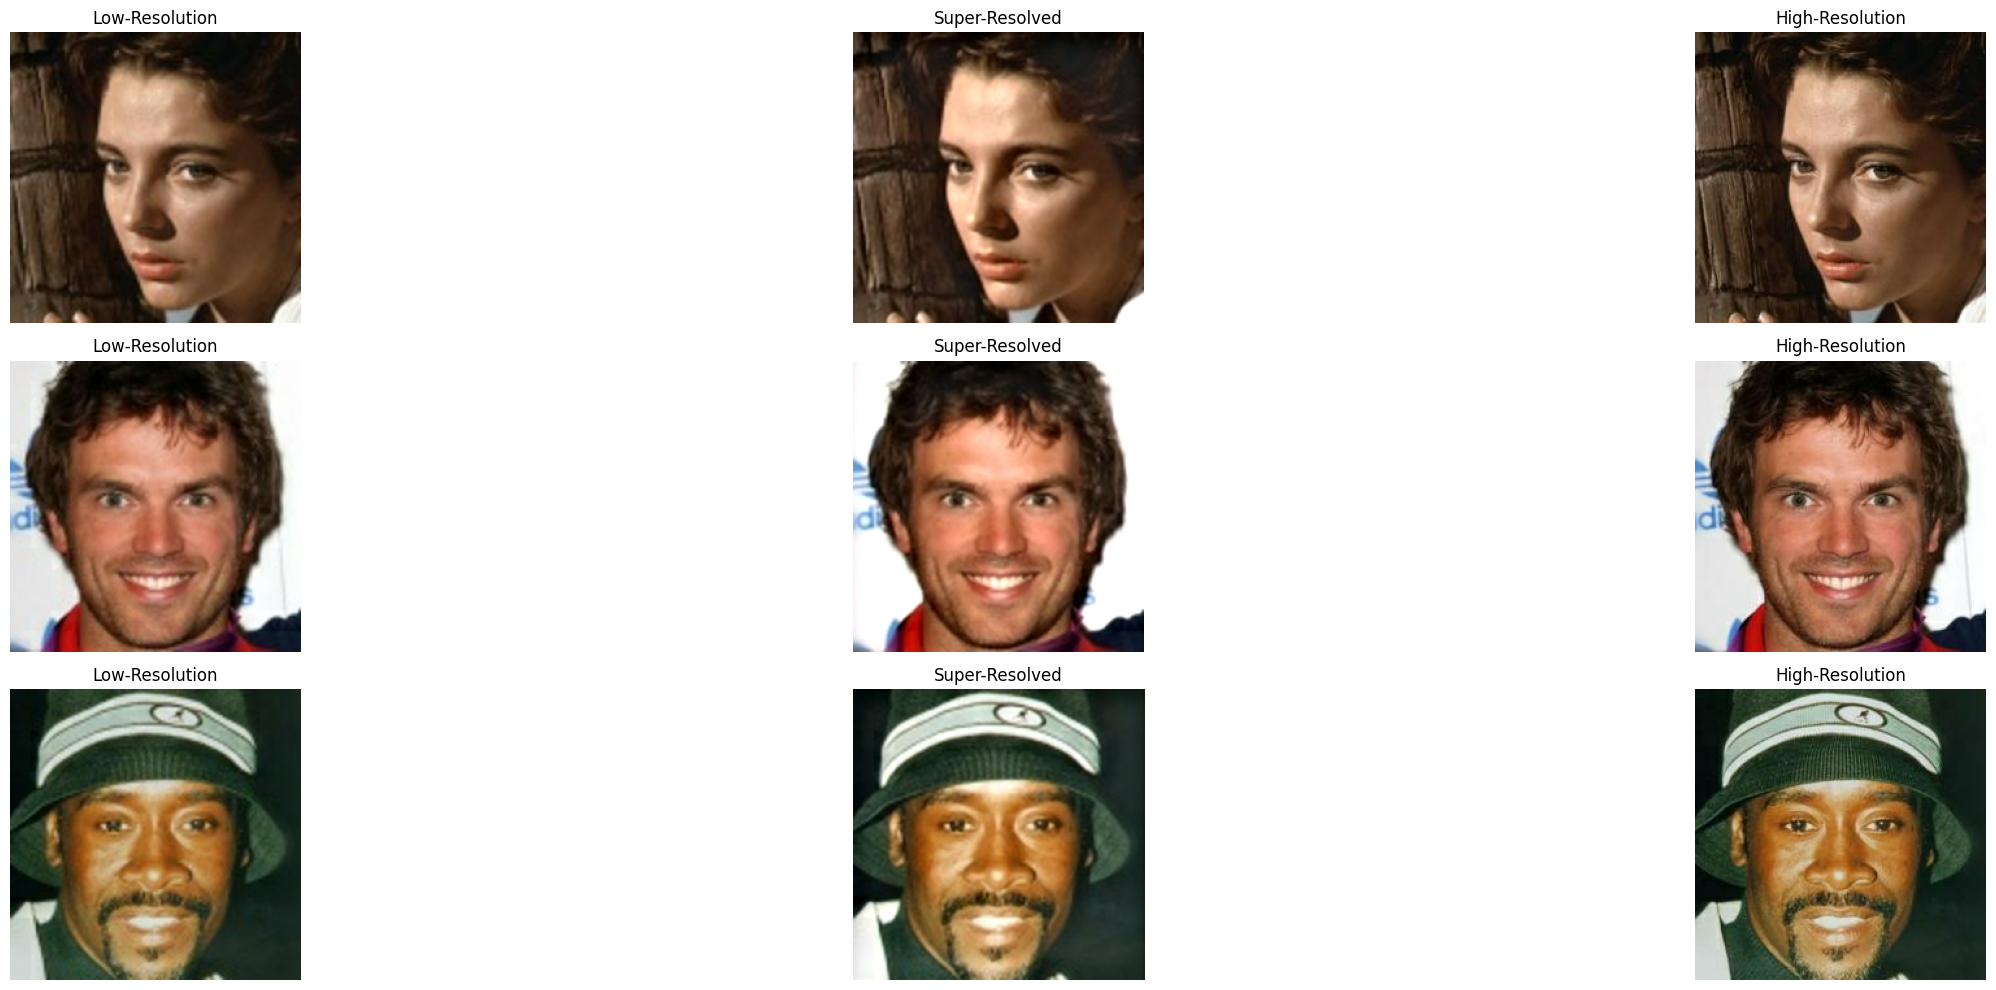

In [ ]:
def plot_images(image_data, n_images, figsize=(30, 10)):
  """
  Plot a batch of images.

  Args:
      image_data (list): List of image data.
      n_images (int): Number of images to plot.
      figsize (tuple): Figure size.
  """
  plt.figure(figsize=figsize)
  titles = ['Low-Resolution', 'Super-Resolved', 'High-Resolution']
  for i in range(n_images):
      lr_img, sr_img, hr_img = image_data[i]
      lr_img = (lr_img + 1) * 127.5
      hr_img = (hr_img + 1) * 127.5
      lr_img = np.clip(lr_img, 0, 255).astype('uint8')
      hr_img = np.clip(hr_img, 0, 255).astype('uint8')
      images = [lr_img, sr_img, hr_img]

      for j, img in enumerate(images):
          if img.dtype != np.uint8:
              img = img.astype(np.uint8)
          plt.subplot(n_images, 3, i * 3 + j + 1)
          plt.imshow(img)
          plt.title(titles[j])
          plt.axis('off')

  plt.tight_layout()
  plt.show()


plot_images(image_data, n_images=N_VISUALISATION)

In [ ]:
len(image_data)

3

In [ ]:
#get a first impression of performance, used for developing
def evaluate_metrics(image_data):
  """
  Evaluate images using PSNR and SSIM metrics.

  Args:
      image_data (list): List of image data.

  Returns:
      list: List of PSNR values.
      list: List of SSIM values.
  """
  psnr_values = []
  ssim_values = []

  for lr_img, sr_img, hr_img in image_data:
      lr_img_float = tf.cast((lr_img + 1) / 2, tf.float32)
      sr_img_float = tf.cast(sr_img / 255.0, tf.float32)
      hr_img_float = tf.cast((hr_img + 1) / 2, tf.float32)

      psnr = tf.image.psnr(hr_img_float, sr_img_float, max_val=1.0)
      ssim = tf.image.ssim(hr_img_float, sr_img_float, max_val=1.0)

      psnr_values.append(psnr.numpy())
      ssim_values.append(ssim.numpy())

  return psnr_values, ssim_values

psnr_values, ssim_values = evaluate_metrics(image_data)
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)

print(f"Average PSNR: {average_psnr:.2f} dB")
print(f"Average SSIM: {average_ssim:.4f}")

Average PSNR: 24.94 dB
Average SSIM: 0.8785


### Perform inference on whole test set, takes around 30 mins to run

In [ ]:
#define function for evaluation (PSNR and SSIM)
def evaluate_metrics(lr_img, sr_img, hr_img):

  lr_img_float = tf.cast((lr_img + 1) / 2, tf.float32)
  sr_img_float = tf.cast(sr_img, tf.float32) / 255.0
  hr_img_float = tf.cast((hr_img + 1) / 2, tf.float32)


  psnr = tf.image.psnr(hr_img_float, sr_img_float, max_val=1.0)
  ssim = tf.image.ssim(hr_img_float, sr_img_float, max_val=1.0)

  return psnr.numpy(), ssim.numpy()

psnr_values = []
ssim_values = []

for low_res_batch, high_res_batch in test_ds:
    sr_batch = perform_inference(model, low_res_batch, time_steps=400)
    for lr_img, sr_img, hr_img in zip(low_res_batch, sr_batch, high_res_batch):
        psnr, ssim = evaluate_metrics(lr_img, sr_img, hr_img)
        psnr_values.append(psnr)
        ssim_values.append(ssim)

average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)

print(f"Average PSNR: {average_psnr:.2f} dB")
print(f"Average SSIM: {average_ssim:.4f}")

Average PSNR: 24.19 dB
Average SSIM: 0.8790


Save model as keras

In [ ]:
#Load model from weights
model = DiffusionModel(time_steps=1000, beta_start=1e-4, beta_end=0.02, image_dims=(224, 224, 3))

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

#create dummy to load model
dummy_low_res_image = np.random.random((1, 224, 224, 3)).astype(np.float32)
dummy_high_res_image = np.random.random((1, 224, 224, 3)).astype(np.float32)
dummy_ts = np.array([0], dtype=np.int32)
noisy_images, _ = model.add_noise(dummy_high_res_image, dummy_ts)
inputs = [dummy_low_res_image, noisy_images]
_ = model(inputs, dummy_ts, training=False)

#load weights
model.load_weights('/content/drive/MyDrive/ST456_project_team_afi/0_SR3_final/SR3_weights.h5')
model.save('/content/drive/MyDrive/ST456_project_team_afi/0_SR3_final/SR3.keras')